# Problem klasyfikacji gęstości (DCP)

## Imports

In [2]:
pip install joblib

In [3]:
pip install pygad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00


In [4]:
import math
import time
import pygad
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

## Wczytywanie konfiguracji Pana Marcina
Pliki z konfiguracjami można pobrać z https://github.com/D3M80L/CA/tree/master/phd/data.

In [5]:
def convert_configuration(configuration: bytes, N: int):
    binary_str = ''.join(f'{byte:08b}' for byte in configuration)
    return np.array([int(bit) for bit in binary_str[:N]])


In [6]:
def configuration_reader(file_name: str, N: int, negate: bool):
    bytes_per_configuration = math.ceil(N / 8)
    configurations = []

    with open(file_name, 'rb') as file:
        while True:
            bytes_read = file.read(bytes_per_configuration)
            if not bytes_read:
                break

            cfg = convert_configuration(bytes_read, N)
            configurations.append(cfg)

            if negate:
                configurations.append(1 - cfg)

    return np.stack(configurations)


---

In [4]:
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
    return lut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]

def eca_evolve_spacetime(lut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(eca_evolve(lut, rows[-1]))
    return np.stack(rows)


In [ ]:
np.random.randint(2, size=9)

array([0, 1, 0, 0, 1, 0, 1, 0, 1])

In [ ]:
lut = eca_get_lut(232)
x = np.array([0,1,1,1,1,1,0,0,0])
eca_evolve(lut, x)

array([0, 1, 1, 1, 1, 1, 0, 0, 0], dtype=uint8)

In [ ]:
eca_evolve_spacetime(lut, x, 18)

array([[0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 0]])

(1D ECA Simulator: https://elife-asu.github.io/wss-modules/modules/1-1d-cellular-automata/)

---
## zad.9 (lekko zmodyfikowane)

Zapoznaj się z wynikami z artykułu:\
*Mendonça, J. R. G. (2019).* **Simply modified GKL density classifiers that reach consensus faster.** *Physics Letters A, 383(19), 2264–2266.
doi:10.1016/j.physleta.2019.04.033* (https://sci-hub.se/https://www.sciencedirect.com/science/article/abs/pii/S0375960119303512?via=ihub)

Spróbuj powtórzyć eksperymenty tam wykonane dla wybranego N dla którego mamy "zbiór Marcina" % poprawnych klasyfikacji dla reguł GKL(j, k) dla kilku, wybranych przez Ciebie przypadków j, k.

**Wariant (*) - zbadaj również średni czas klasyfikacji - tzn. czy widać, które reguły są szybsze od innych.**

### Implementacja GKL(j, k)
$
x^{t+1}_i =
\begin{cases}
\text{maj}(x^t_{i-k}, x^t_{i-j}, x^t_i) & \text{jeśli } x^t_i = 0, \\
\text{maj}(x^t_i, x^t_{i+j}, x^t_{i+k}) & \text{jeśli } x^t_i = 1,
\end{cases}
$

gdzie wybieramy sąsiadów $i\pm j$ oraz $i\pm k$ takich, że $k>j\geq i$.

In [ ]:
def majority(p, q, r):
    return np.floor(0.5 * (p + q + r))

def gkl_step(x: np.ndarray, j: int, k: int) -> np.ndarray:
    x_left = np.roll(x, j)
    x_right = np.roll(x, -j)
    x_far_left = np.roll(x, k)
    x_far_right = np.roll(x, -k)

    new_x = np.where(x == 0, majority(x_far_left, x_left, x), majority(x, x_right, x_far_right))
    return new_x


In [ ]:
def gkl_spacetime(initial_conf: np.ndarray, j: int, k: int, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(gkl_step(rows[-1], j, k))
    return np.stack(rows)


Dla k = -1, j = 1 otrzymujemy te same wyniki co w `eca_evolve()` i `eca_evolve_spacetime()` dla ECA 232 (majority):

In [ ]:
gkl_step(x, -1, 1)

array([0., 1., 1., 1., 1., 1., 0., 0., 0.])

In [ ]:
gkl_spacetime(x, -1, 1, 18)

array([[0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 0., 0., 0.]])

### Eksperyment dla N = 23

In [ ]:
configurations = configuration_reader("ALL_N23.bin", 23, True)
len(configurations)

364724

Funkcja do klasyfikacji gęstości:

In [ ]:
def dcp_gkl(initial_config, j, k, steps):
    initial_density = sum(initial_config)/len(initial_config)
    config = gkl_spacetime(initial_config, j, k, steps)[-1]
    result_density = sum(config)/len(config)

    if initial_density < 0.5:
        if result_density < 0.5:
            return 1
        else:
            return 0
    if initial_density > 0.5:
        if result_density > 0.5:
            return 1
        else:
            return 0
    return 0


In [ ]:
neighbors = [(4,12), (3,9), (2,6), (5,15), (1,3), (1,9), (1,11), (2,14), (2,10), (3,15), (1,7), (1,5)]
results = []
times = []

for j, k in neighbors:
    print(f'GKL({j},{k})')

    start_time = time.time()
    l = Parallel(n_jobs=-1)(delayed(dcp_gkl)(config, j, k, 46) for config in configurations)
    end_time = time.time()
    t = end_time - start_time
    times.append(round(t, 5))

    results.append(round(sum(l)/len(configurations),5))
    print(f'Poprawna klasyfikacja gęstości: {100*results[-1]}%')
    print(f'Czas wykonania: {times[-1]} sekund')
    print()

GKL(4,12)
Poprawna klasyfikacja gęstości: 90.515%
Czas wykonania: 278.20585 sekund

GKL(3,9)
Poprawna klasyfikacja gęstości: 90.515%
Czas wykonania: 288.81525 sekund

GKL(2,6)
Poprawna klasyfikacja gęstości: 90.515%
Czas wykonania: 290.2187 sekund

GKL(5,15)
Poprawna klasyfikacja gęstości: 90.515%
Czas wykonania: 330.15819 sekund

GKL(1,3)
Poprawna klasyfikacja gęstości: 90.515%
Czas wykonania: 316.66102 sekund

GKL(1,9)
Poprawna klasyfikacja gęstości: 91.244%
Czas wykonania: 352.0376 sekund

GKL(1,11)
Poprawna klasyfikacja gęstości: 89.876%
Czas wykonania: 333.32634 sekund

GKL(2,14)
Poprawna klasyfikacja gęstości: 91.621%
Czas wykonania: 301.38556 sekund

GKL(2,10)
Poprawna klasyfikacja gęstości: 90.728%
Czas wykonania: 332.68055 sekund

GKL(3,15)
Poprawna klasyfikacja gęstości: 90.728%
Czas wykonania: 340.35098 sekund

GKL(1,7)
Poprawna klasyfikacja gęstości: 91.621%
Czas wykonania: 328.28764 sekund

GKL(1,5)
Poprawna klasyfikacja gęstości: 90.728%
Czas wykonania: 286.03217 sekund



In [ ]:
df = pd.DataFrame({'correctness': results, 'time': times}, index=neighbors)
df.T

,"(4, 12)","(3, 9)","(2, 6)","(5, 15)","(1, 3)","(1, 9)","(1, 11)","(2, 14)","(2, 10)","(3, 15)","(1, 7)","(1, 5)"
correctness,0.90515,0.90515,0.90515,0.90515,0.90515,0.91244,0.89876,0.91621,0.90728,0.90728,0.91621,0.90728
time,278.20585,288.81525,290.21870,330.15819,316.66102,352.03760,333.32634,301.38556,332.68055,340.35098,328.28764,286.03217


---
# Algorytmy ewolucyjne

## zad.11

Zaimplementuj algorytm ewolucyjny, który poszukuje rozwiązań DCP wśród binarnych automatów komórkowych o promieniu sąsiedztwa r=2, dla liczby komórek N=23 (korzystając ze zbioru Marcina) i limitu czasu T = 2*N. Zdecyduj sama / sam ile populacji i jak duże populacje potrzebujesz - możesz to określić robiąc eksperymenty. Możesz również dowolnie manipulować mutacjami, krzyżowaniem, selekcją itd.

Jaki najlepszy wynik (największą liczbę poprawnie sklasyfikowanych konfiguracji) uda Ci się uzyskać? Podaj LUT najlepszej, znalezionej przez Twój algorytm reguły.

Uzyskane przez nas wszystkich reguły porównam na zbiorach N=23 i większych, jak tylko otrzymam wszystkie rozwiązania i wyłonimy zwycięzców. Może uda się komuś z nas pobić GKL?

Sugestie:
- Do wstępnych testów możesz najpierw użyć mniejszego N i zamiast zbioru Marcina, użyć mniejszy zbiór wygenerowany losowo - program będzie działać szybciej, zatem szybciej będziesz wprowadzać w nim zmiany.
- Koniecznie użyj przetwarzania równoległego aby w pełni wykorzystać moc współczesnych procesorów oraz cache’owania - tak, żeby nie przeliczać tej samej reguły CA wiele razy.
- GitHub CodeSpaces dają 4-rdzeniowy procesor w chmurze dostępny za darmo (30 lub 60 godzin obliczeń w miesiącu).
- Czy dla każdego wyliczenia wartości funkcji dopasowania trzeba używać cały zbiór warunków początkowych? Może aby było szybciej, dla każdej populacji można losować pewien podzbiór zbioru warunków początkowych i dzięki temu szybciej tworzyć nowe populacje? (A może te podzbiory też powinny podlegać “ewolucji”? Mamy wtedy do czynienia z koewolucją.)
- Przedyskutuj to zagadnienie z ChatGPT. Poproś o sugestie, pomysły na usprawnienia kodu itd!

In [ ]:
# ECA to automaty o promieniu r=1, teraz mamy r=2, czyli sąsiedztwo 5
# trzeba zmodyfikować eca_get_lut(do 32 a nie 8) i eca_evolve()
# podać lut, który wyszedł jako najlepszy

In [15]:
configurations = configuration_reader("ALL_N23.bin", 23, True)
len(configurations)

364724

In [16]:
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(32)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
    return lut[31 - (np.roll(x, 2) * 16 + np.roll(x, 1) * 8 + x * 4 + np.roll(x, -1) * 2 + np.roll(x, -2)).astype(int)]

def eca_evolve_spacetime(lut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(eca_evolve(lut, rows[-1]))
    return np.stack(rows)


Mamy teraz $2^{2^{5}}=2^{32}$ różnych reguł.

In [9]:
2**32

4294967296

In [17]:
def cross(x, y):
    point = np.random.randint(len(x))
    return np.concatenate((x[:point], y[point:]))

# def mutate(x, mutation_rate):
def mutate(x):
    mutation_rate = random.random()
    # zmieniamy wartość losowego elementu na przeciwną
    if mutation_rate <= 0.5:
      index = np.random.randint(len(x))  # Wybierz losowy indeks
      x[index] = 1 - x[index]  # Zmień wartość na przeciwną
      return x
    # zamieniamy dwa losowe elementy miejscami
    if mutation_rate > 0.5:
      index1, index2 = np.random.choice(len(x), 2, replace=False)
      x[index1], x[index2] = x[index2], x[index1]
      return x

def choice(population, fitness_values):
    return population[np.random.choice(len(population), p=fitness_values)]


In [18]:
def fitness(x, func):
    l = Parallel(n_jobs=-1)(delayed(func)(x, config, steps) for config in random_configs)
    return round(sum(l)/1000,3)

def fitness_on_population(population, func):
    res = np.array([fitness(x, func) for x in population])
    s = sum(res)
    return res / s

def ga_solve(func, population_size = 20, iterations = 1000):
    population = np.random.randint(2, size=(100, 32))
    best_fitness = -np.inf
    best_chromosome = None

    for _ in range(iterations):
        fitness_results = fitness_on_population(population, func)
        population = np.array([mutate(
            cross(
                choice(population, fitness_results),
                choice(population, fitness_results)))
                               for _ in range(population_size)])

    max_fitness_index = np.argmax(fitness_results)
    if fitness_results[max_fitness_index] > best_fitness:
        best_fitness = fitness_results[max_fitness_index]
        best_chromosome = population[max_fitness_index]

    return best_chromosome, best_fitness


In [19]:
def dcp(lut, initial_config, steps):
    initial_density = sum(initial_config)/len(initial_config)
    config = eca_evolve_spacetime(lut, initial_config, steps)[-1]
    result_density = sum(config)/len(config)

    if initial_density < 0.5:
        if result_density < 0.5:
            return 1
        else:
            return 0
    if initial_density > 0.5:
        if result_density > 0.5:
            return 1
        else:
            return 0
    return 0


In [20]:
# definiujemy potrzebane parametry
f = dcp
steps = 46
configurations_list = configurations.tolist()
random_configs_list = random.sample(configurations_list, 1000)
random_configs = np.array(random_configs_list)

start = time.time()
# iterations to liczba pokoleń
best_candidate, best_fitness = ga_solve(f, population_size = 100, iterations = 20)
end = time.time()
czas = end - start
print("Czas: ", czas)

Czas:  6421.701444387436


Rozmiar populacji 100 i liczba pokoleń 20 to zdecydowanie za mało, żeby wyłonić najlepsze rozwiązanie. Obliczenia przy tych parametrach i dla 1000 wybranych konfiguracji spośród konfiguracji Pana Marcina o długości 23 trwały prawie 2h.

In [21]:
print("Best candidate: ", best_candidate)
print("Fitness value of the best candidate= ", best_fitness)
best_candidate_int = best_candidate.astype(int)
binary_str = ''.join(map(str, best_candidate_int))
best = int(binary_str, 2)
print("Best candidate: ", best)

Best candidate:  [0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 1]
Fitness value of the best candidate=  0.013248458325044761
Best candidate:  1373329587


In [22]:
# sprawdzamy dla wszystkich konfiguracji z listy konfiguracji Pana Marcina
l = Parallel(n_jobs=-1)(delayed(dcp)(best_candidate, config, 46) for config in configurations)
print(f"Correct density classification: {round(100*sum(l)/len(configurations),3)}")

Correct density classification: 50.054


- Najlepsze znalezione rozwiązanie to **[0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]**.
- Najlepsza wyłoniona reguła: **1373329587**.
- Procent poprawnych klasyfikacji: **50.054%**.

### Jak ulepszyć kod?
Oto kilka sugestii, które mogą pomóc w ulepszeniu Twojego kodu:

1. **Parametryzacja funkcji**: Możesz zrobić swoje funkcje bardziej elastycznymi, dodając więcej parametrów. Na przykład, w funkcji `mutate`, możesz dodać parametr `mutation_rate`, który określa prawdopodobieństwo mutacji. W ten sposób możesz łatwo dostosować stopień mutacji bez konieczności modyfikowania samej funkcji.

2. **Ewaluacja wydajności**: Możesz dodać logowanie lub inne metody śledzenia, aby monitorować postęp algorytmu ewolucyjnego. To może pomóc Ci zrozumieć, jak algorytm działa i gdzie mogą występować problemy.

3. **Optymalizacja wydajności**: W funkcji `fitness`, używasz równoległego przetwarzania do obliczania wartości funkcji dla różnych konfiguracji. To jest dobre, ale pamiętaj, że równoległe przetwarzanie może być kosztowne pod względem zasobów, szczególnie jeśli liczba konfiguracji jest duża. Możesz rozważyć użycie technik takich jak próbkowanie lub inne metody redukcji wymiarowości, aby zmniejszyć liczbę konfiguracji, które musisz przetworzyć.

4. **Eksploracja różnych strategii ewolucyjnych**: W Twoim algorytmie ewolucyjnym, używasz krzyżowania jednopunktowego i mutacji polegającej na zmianie losowego bitu. Istnieje wiele innych strategii krzyżowania i mutacji, które mogą być skuteczne w różnych sytuacjach. Możesz spróbować eksperymentować z różnymi strategiami, aby zobaczyć, które z nich działają najlepiej dla Twojego problemu.

5. **Koewolucja**: Wspomniałeś o możliwości "ewolucji" podzbiorów zbioru warunków początkowych. To jest bardzo interesujący pomysł, który prowadzi do koncepcji koewolucji. W koewolucji, dwie lub więcej populacji ewoluują razem, wpływając na siebie nawzajem. Możesz spróbować zaimplementować to w swoim algorytmie i zobaczyć, jak to wpływa na wyniki.

## To samo za pomocą PyGAD
(https://pygad.readthedocs.io/en/latest/pygad.html#functions-in-pygad)

In [7]:
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(32)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
    return lut[31 - (np.roll(x, 2) * 16 + np.roll(x, 1) * 8 + x * 4 + np.roll(x, -1) * 2 + np.roll(x, -2)).astype(int)]

def eca_evolve_spacetime(lut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(eca_evolve(lut, rows[-1]))
    return np.stack(rows)


In [8]:
# lut to będzie solution
def dcp(lut, initial_config, steps):
    initial_density = sum(initial_config)/len(initial_config)
    config = eca_evolve_spacetime(lut, initial_config, steps)[-1]
    result_density = sum(config)/len(config)

    if initial_density < 0.5:
        if result_density < 0.5:
            return 1
        else:
            return 0
    if initial_density > 0.5:
        if result_density > 0.5:
            return 1
        else:
            return 0
    return 0


In [9]:
configurations = configuration_reader("ALL_N23.bin", 23, True)
len(configurations)

364724

In [10]:
# definiujemy parametry rozwiązania
# gene_space to zbiór możliwych wartości przyjmowanych przez geny w chromosomie
gene_space = [0, 1]

# funkcja celu
def fitness_func(ga_instance, solution, solution_idx):
    fitness = 0
    # losujemy 1000 konfiguracji z listy konfiguracji Pana Marcina
    configurations_list = configurations.tolist()
    random_configs_list = random.sample(configurations_list, 1000)
    random_configs = np.array(random_configs_list)
    l = Parallel(n_jobs=-1)(delayed(dcp)(solution, config, 46) for config in random_configs)
    # l = [dcp(solution, config, 46) for config in configurations]
    fitness = round(sum(l)/1000,3)
    return fitness

fitness_function = fitness_func

In [11]:
# ile chromosomów w populacji
sol_per_pop = 100
# ile genów ma chromosom
num_genes = 32

# ile wyłaniamy rodziców do "rozmnażania" (okolo 50% populacji)
num_parents_mating = 50
# ile pokoleń
num_generations = 20
# ilu rodziców zachować (kilka procent)
keep_parents = 2

# jaki typ selekcji rodziców?
#sss = steady, rws=roulette, rank = rankingowa, tournament = turniejowa
parent_selection_type = "sss"

# w ilu punktach robić krzyżowanie?
#single_point, two_points, uniform, scattered
crossover_type = "single_point"

# mutacja ma działać na ilu procent genów?
#random, swap - zamienia miejscami dwa geny, inversion - zmienia kolejność fragmentu chromosomu, scramble, adaptive
#displacament - przeniesienie części genów w inne miejsce
mutation_type = "random"
mutation_percent_genes = 4 # 32*0.04 czyli 1 gen sie zmieni

In [12]:
def on_gen(ga_instance):
    print("Generation: ", ga_instance.generations_completed)
    print("Fitness of the best solution:", ga_instance.best_solution()[1])


In [13]:
start = time.time()

# inicjacja algorytmu z powyższymi parametrami wpisanymi w atrybuty
ga_instance = pygad.GA(
    gene_space=gene_space,
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=fitness_function,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    parent_selection_type=parent_selection_type,
    # keep_elitism=0, # tak pozbywamy się elityzmu, zachowując rodziców funkcja może utknąć w maksimum lokalnym
    keep_parents=keep_parents,
    crossover_type=crossover_type,
    mutation_type=mutation_type,
    mutation_percent_genes=mutation_percent_genes,
    on_generation=on_gen,
    stop_criteria='reach_1' # możemy ustawić warunek zatrzymania
)

# uruchomienie algorytmu
ga_instance.run()

end = time.time()
czas = end - start
print("Czas: ", czas)

solution, solution_fitness, solution_idx = ga_instance.best_solution()

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation:  1
Fitness of the best solution: 0.628
Generation:  2
Fitness of the best solution: 0.639
Generation:  3
Fitness of the best solution: 0.724
Generation:  4
Fitness of the best solution: 0.766
Generation:  5
Fitness of the best solution: 0.836
Generation:  6
Fitness of the best solution: 0.827
Generation:  7
Fitness of the best solution: 0.827
Generation:  8
Fitness of the best solution: 0.827
Generation:  9
Fitness of the best solution: 0.827
Generation:  10
Fitness of the best solution: 0.827
Generation:  11
Fitness of the best solution: 0.827
Generation:  12
Fitness of the best solution: 0.849
Generation:  13
Fitness of the best solution: 0.829
Generation:  14
Fitness of the best solution: 0.829
Generation:  15
Fitness of the best solution: 0.839
Generation:  16
Fitness of the best solution: 0.86
Generation:  17
Fitness of the best solution: 0.865
Generation:  18
Fitness of the best solution: 0.867
Generation:  19
Fitness of the best solution: 0.867
Generation:  20
Fitnes

In [14]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

#ile pokoleń
print("Number of generations passed is: {generations_completed}".format(generations_completed=ga_instance.generations_completed))

#podsumowanie: najlepsze znalezione rozwiązanie (reguła + ocena)
print(f"Parameters of the best solution: {solution}")
solution_int = solution.astype(int)
binary_string = ''.join(map(str, solution_int))
rule = int(binary_string, 2)
print(f"The best solution is the rule: {rule}")
print(f"Fitness value of the best solution = {solution_fitness}")

Number of generations passed is: 20
Parameters of the best solution: [1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0.]
The best solution is the rule: 4108384480
Fitness value of the best solution = 0.867


In [15]:
# sprawdzamy dla wszystkich konfiguracji z listy Pana Marcina
l = Parallel(n_jobs=-1)(delayed(dcp)(solution, config, 46) for config in configurations)
print(f"Correct density classification: {round(100*sum(l)/len(configurations),3)}")

Correct density classification: 86.103


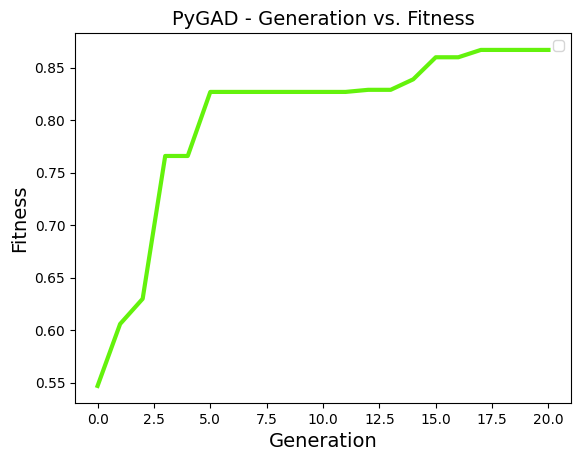

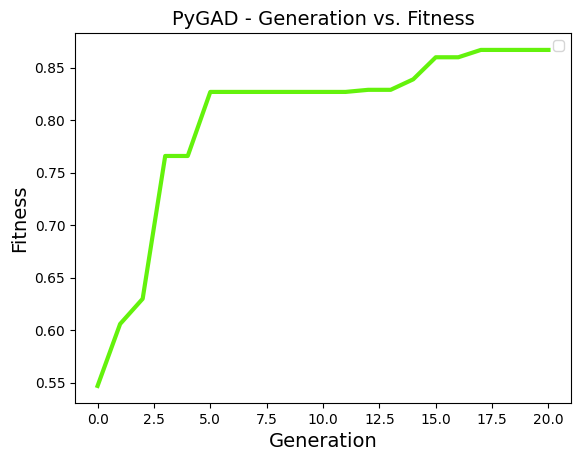

In [16]:
# wyświetlenie wykresu: jak zmieniała sie ocena na przestrzeni pokoleń
ga_instance.plot_fitness()

Pierwsze uruchomienie algorytmu PyGAD:
- Czas wykonania: prawie 2h.
- Algorytm został zatrzymany po 10 pokoleniach, ponieważ znalazł regułę, która ma fitness = 1. Jednak wartość fitness najlepszego rozwiązania wynosiła 0.884, a nie 1 (nie wiem dlaczego ☹, wykres plot_fitness() również wskazywał na osiągnięcie wyniku 1).
- Najlepszym wyłonionym rozwiązaniem było: **[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]**, co odpowiada regule **4159763200**.
- Procent poprawnych klasyfikacji gęstości dla całego zbioru konfiguracji Pana Marcina wyniósł **88.281%**.

Drugie uruchomienie:
- Czas wykonania: ponad 4.5h.
- Algorytm przeszedł 20 pokoleń. Wartość fitness najlepszego rozwiązania wynosiła 0.884.
- Najlepszym wyłonionym rozwiązaniem było: **[1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]**, co odpowiada regule **4108384480**.
- Procent poprawnych klasyfikacji gęstości dla całego zbioru konfiguracji Pana Marcina wyniósł **86.103%**.